In [1]:
import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['axes.prop_cycle'] = cycler(color=["black","blue","orange",'green'])

/tmp/ipykernel_4266/3878834137.py:15: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
rank = 2 # rank of hamiltonian
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

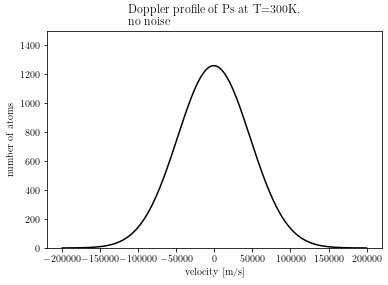

In [3]:
N_atoms = int(1e5)

T = 300 #K temperature of cloud
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
std_deviation = np.sqrt(k*T/m) #standard deviation of gaussian
amplitude = np.sqrt(m/(2*np.pi*k*T))
N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps


velocity_bins = np.linspace(-2e5,2e5,N_bins) #m/s
populations = np.zeros(N_bins)
for i in range(N_bins-1):
    populations[i] = sp.integrate.quad(lambda v: amplitude*np.exp(-v**2/(2*std_deviation**2))*1e5,velocity_bins[i],velocity_bins[i+1])[0]
    # see if it is necessary to integrate. just take the analytical function and divide/multiply by dv
plt.plot(velocity_bins,populations)
plt.ylim(0,1500)
plt.xlabel("velocity [m/s]")
plt.ylabel("number of atoms")
plt.title("Doppler profile of Ps at T=300K,\n no noise")
plt.show()

In [4]:
velocity_bins = velocity_bins*1e-10 #cm/ps
# create new vector to track population: (velocity at bin, excited population)
data_in_bins = np.asarray([(velocity_bins[i],populations[i]) for i in range(N_bins)])
print(data_in_bins[150])

[2.55639098e-06 1.08019659e+03]


In [5]:
endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
print(velocity_change_per_photon*1e10, "m/s")
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*100
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)


pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)



1498.728915411178 m/s


In [6]:
#direction = +/-, depends on direction of incoming laser
def evolve(velocity_bins,pulse_kwargs):
    omega0 = pulse_kwargs["omega0"]
    detuning = pulse_kwargs["detuning"]
    chirp= pulse_kwargs["chirp"]
    rabi0= pulse_kwargs["rabi0"]
    pulse_duration = pulse_kwargs["pulse_duration"]
    direction = pulse_kwargs["direction"]
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)
    
    final_states = []
    for vel in velocity_bins:
        H0 = hbar*qt.Qobj([[0,0],[0,omega0*direction*vel/c +detuning*(1+direction*vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+direction*vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]

        result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)
        #current_state = qt.Qobj([[result.expect[0][-1]],[result.expect[1][-1]]])
        final_states.append(result.expect[1][-1])
    
    return final_states 

In [27]:
rabi0 = 2*np.pi*(200e-3) #THz
detuning = 0#2*np.pi*(-152e-3) #THz
chirp = 2*np.pi*(70e-3) #THz

In [28]:
final_states = evolve(velocity_bins,omega0,detuning,chirp,rabi0,pulse_duration) 

0.38971085156409485


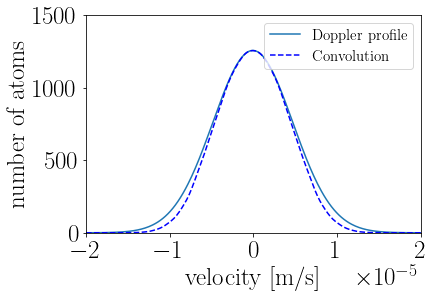

In [38]:
final_pops = np.asarray([np.abs(final_states[i][1][0][0]) for i in range(len(final_states))])
print(populations[5])
plt.plot(velocity_bins,populations,label="Doppler profile")
plt.plot(velocity_bins,final_pops*populations,color="blue",ls="dashed",label="Convolution")
plt.xlabel("velocity [m/s]")
plt.ylabel("number of atoms")
plt.ylim(0,1500)
plt.xlim(-2e-5,2e-5)
plt.legend(fontsize="15")
plt.show()

In [42]:
"""
detunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])
final_pops = np.zeros((5,N_bins))
evolved_states = []
for i in range(detunings.size):
    evolved_states.append(evolve(omega0,detunings[i],chirp=0,rabi0=2*np.pi*(240e-3),pulse_duration=10))
    final_pops[i] = np.asarray([np.abs(evolved_states[i][j][1][0][0]) for j in range(N_bins)])
"""

'\ndetunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])\nfinal_pops = np.zeros((5,N_bins))\nevolved_states = []\nfor i in range(detunings.size):\n    evolved_states.append(evolve(omega0,detunings[i],chirp=0,rabi0=2*np.pi*(240e-3),pulse_duration=10))\n    final_pops[i] = np.asarray([np.abs(evolved_states[i][j][1][0][0]) for j in range(N_bins)])\n'

In [41]:
"""
fig,axs = plt.subplots(detunings.size,3,figsize=(20,15))

for i in range(detunings.size):
    axs[i][0].hist(velocities,bins=N_bins,alpha=0.5,color="orange")
    axs[i][0].plot(velocity_bins,final_pops[i]*populations)
    axs[i][0].set_xlabel("velocity [cm/ps]")

    shifted_states = update_states(populations,evolved_states[i])
    axs[i][1].plot(velocity_bins, states[1],label="initial")
    axs[i][1].plot(velocity_bins,shifted_states,label="shifted")
    axs[i][1].set_xlabel("velocity [cm/ps]")
    #plt.legend()

    diffs = shifted_states - states[1]
    axs[i][2].plot(velocity_bins,diffs)
    axs[i][2].set_xlabel("velocity [cm/ps]")

    
    
fig.tight_layout()
plt.savefig("./figures/cmt/shifts.jpg")
plt.show()

"""

'\nfig,axs = plt.subplots(detunings.size,3,figsize=(20,15))\n\nfor i in range(detunings.size):\n    axs[i][0].hist(velocities,bins=N_bins,alpha=0.5,color="orange")\n    axs[i][0].plot(velocity_bins,final_pops[i]*populations)\n    axs[i][0].set_xlabel("velocity [cm/ps]")\n\n    shifted_states = update_states(populations,evolved_states[i])\n    axs[i][1].plot(velocity_bins, states[1],label="initial")\n    axs[i][1].plot(velocity_bins,shifted_states,label="shifted")\n    axs[i][1].set_xlabel("velocity [cm/ps]")\n    #plt.legend()\n\n    diffs = shifted_states - states[1]\n    axs[i][2].plot(velocity_bins,diffs)\n    axs[i][2].set_xlabel("velocity [cm/ps]")\n\n    \n    \nfig.tight_layout()\nplt.savefig("./figures/cmt/shifts.jpg")\nplt.show()\n\n'

In [43]:
"""
diff = np.asarray(states[1]-states_after_one_pulse[1])
plt.plot(velocity_bins, diff)
plt.ylabel("difference between populations")
plt.xlabel("velocity [cm/ps]")
"""

'\ndiff = np.asarray(states[1]-states_after_one_pulse[1])\nplt.plot(velocity_bins, diff)\nplt.ylabel("difference between populations")\nplt.xlabel("velocity [cm/ps]")\n'

In [13]:
# momentum is +/- 1 units of photon momentum,
# and depends on the direction of the incoming laser.
def update_states(pops, transitions, momentum):
    temp_pops = pops
    new_pops = np.zeros(N_bins)
    for i in range(2,N_bins-2):
        new_pops[i] = temp_pops[i]*(1-transitions[i]) + temp_pops[i+momentum]*transitions[i+momentum]
    return new_pops

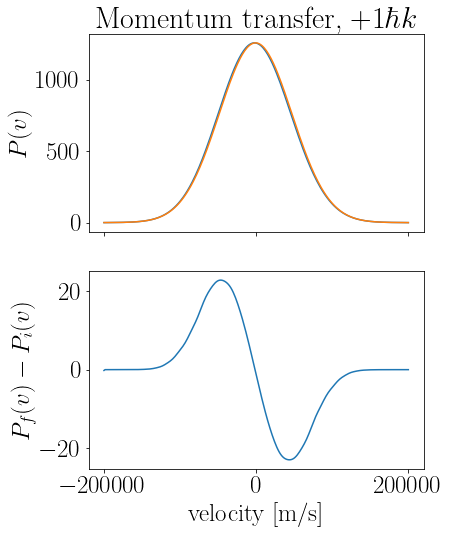

In [71]:
new_population = update_states(populations,final_states,+1)
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)

axs[0].plot(velocity_bins*1e10,new_population)
axs[0].plot(velocity_bins*1e10,populations)
axs[1].plot(velocity_bins*1e10,new_population-populations)
axs[1].set_xlabel("velocity [m/s]")
axs[0].set_ylabel(r"$P(v)$")
axs[1].set_ylabel(r"$P_f(v)-P_i(v)$")
axs[0].set_title(r"Momentum transfer, $+1\hbar k$")
#plt.savefig("figures/cmt/momentum_transfer_plus_one.jpg")
plt.show()

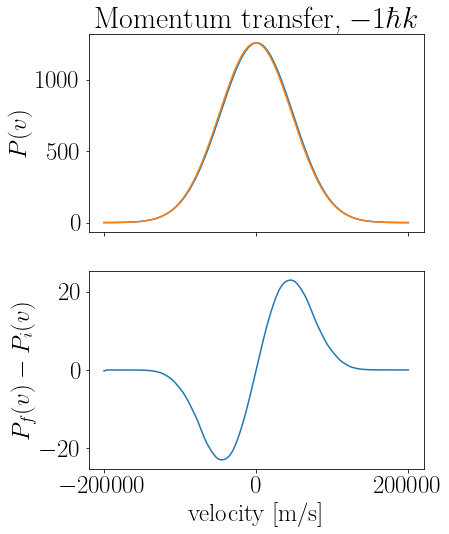

In [72]:
new_population = update_states(populations,final_states,-1)
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)

axs[0].plot(velocity_bins*1e10,new_population)
axs[0].plot(velocity_bins*1e10,populations)
axs[1].plot(velocity_bins*1e10,new_population-populations)
axs[1].set_xlabel("velocity [m/s]")
axs[0].set_ylabel(r"$P(v)$")
axs[1].set_ylabel(r"$P_f(v)-P_i(v)$")
axs[0].set_title(r"Momentum transfer, $-1\hbar k$")
#plt.savefig("figures/cmt/momentum_transfer_minus_one.jpg")
plt.show()

In [7]:
pump_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(-152e-3),"chirp" : 0,"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
dump_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(152e-3),"chirp" : 0,"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":-1}
transitions_pump = evolve(velocity_bins,pump_pulse_dict)
transitions_dump = evolve(velocity_bins,dump_pulse_dict)

In [21]:
pump_pulse_dict["transitions"] = transitions_pump
dump_pulse_dict["transitions"] = transitions_dump

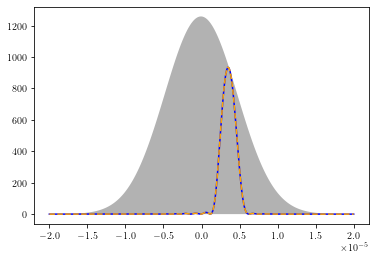

In [10]:
#pops_pump = np.abs([transitions_pump[i][1][0][0] for i in range(N_bins)])
#pops_dump = np.abs([transitions_dump[i][1][0][0] for i in range(N_bins)])
plt.fill_between(velocity_bins,0,populations,alpha=0.3)
plt.plot(velocity_bins,transitions_pump*populations,color="blue")
plt.plot(velocity_bins,transitions_dump*populations,color="orange",ls="dashed")
plt.show()

In [14]:

def pump_dump_cycle(initial_pops,time_ordered_pulse_train):
    temp_pops = initial_pops
    for pulse in time_ordered_pulse_train:
        if pulse == "pump":
            transitions = transitions_pump
            momentum_change = 1 
        elif pulse == "dump":
            transitions = transitions_dump
            momentum_change = 1
      
        temp_pops = update_states(temp_pops,transitions,momentum_change)

    new_pops = temp_pops
    return new_pops


0
1
2
Initial number of atoms: 99997 Final number of atoms: 99996
diff between peak of interaction and trough is ~12500m/s, ~8 units of momentum, same with peak of interaction and peak in doppler cooling profile
diff in velocity between peak and trough: ~22500 m/s. One unit of photon momentum is ~1500m/s, so this is a change in about 17 units of momentum.


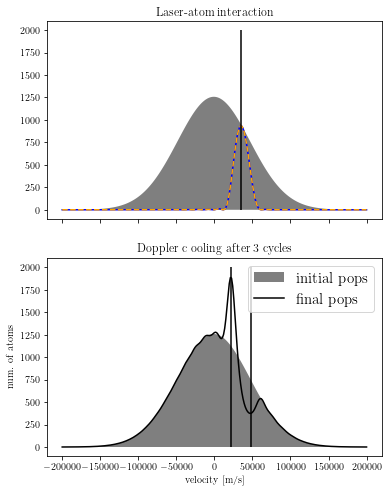

In [43]:
train = ["pump","dump"]

N_cycles = 3
pops = populations
for i in range(N_cycles):
    pops = pump_dump_cycle(pops,train)
    
print("Initial number of atoms:", int(np.sum(populations)), "Final number of atoms:", int(np.sum(pops)))
print("diff between peak of interaction and trough is ~12500m/s, ~8 units of momentum, same with peak of interaction and peak in doppler cooling profile")
print("diff in velocity between peak and trough: ~22500 m/s. One unit of photon momentum is ~1500m/s, so this is a change in about 17 units of momentum.")
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)
axs[0].fill_between(velocity_bins*1e10,0,populations,alpha=0.5)
axs[0].plot(velocity_bins*1e10,transitions_pump*populations,color="blue")
axs[0].plot(velocity_bins*1e10,transitions_dump*populations,color="orange",ls="dashed")
axs[0].set_title("Laser-atom interaction")
axs[0].vlines(35000,0,2000)

axs[1].vlines(22000,0,2000)
axs[1].vlines(47500,0,2000)
axs[1].fill_between(velocity_bins*1e10,0,populations,label="initial pops",alpha=0.5)
axs[1].plot(velocity_bins*1e10,pops, label="final pops")
axs[1].set_xlabel("velocity [m/s]")
axs[1].set_ylabel("num. of atoms")
axs[1].set_title("Doppler c ooling after {} cycles".format(N_cycles))
axs[1].legend(fontsize="15")

#plt.savefig("./figures/cmt/doppler_cooling.jpg")
plt.show()

In [8]:
desymmetrizing_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(-200e-3),"chirp" : 2*np.pi*(30e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
flip_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 0,"chirp" : 2*np.pi*(70e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
transitions_desymmetrize = evolve(velocity_bins,desymmetrizing_pulse_dict)
transitions_flip = evolve(velocity_bins, flip_pulse_dict)


For this 2-level system I will assume that the transition probability $\alpha$ for $\ket{g}\rightarrow\ket{e}$ is the same as for $\ket{e}\rightarrow\ket{g}$, such that
$$
P_{gf} = P_{gi} - P_{gi}\cdot\alpha + P_{fi}\cdot\alpha 
$$
This can be conveniently written with matrix notation, such that such that
$$
A = 
\begin{pmatrix}
1-\alpha & \alpha \\
\alpha & 1-\alpha
\end{pmatrix}
$$
Starting from a population vector $P = (P_g,P_e)$, one can perform a dot product between them ($P_f = AP_i$) to find out quickly the new population due to the transitions.
If one has a series of pulses affecting the population, one can calculate the population by performing a matrix multiplication such that
$$
P_f = B A P_i,
$$
where $B$ is an analogous transition matrix, with its own transition rate, but defined the same as $A$

99997.25186719955


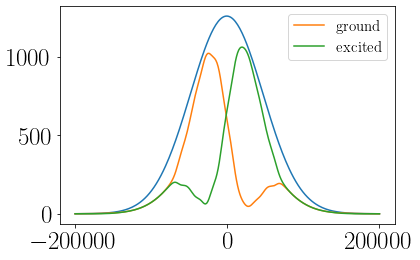

In [59]:
#HOLY SHIT this actually works kinda. bruh

new_pops = []
num_pulses = 10
for i in range(N_bins):
    full_pops_initial = np.asarray([populations[i],0])
    alpha = transitions_desymmetrize[i]
    beta = transitions_flip[i]
    pulse_1 = np.asarray([[1-alpha,alpha],[alpha,1-alpha]])
    pulse_2 = np.asarray([[1-beta,beta],[beta,1-beta]])
    
    temp_pops = pulse_1.dot(full_pops_initial)
    for i in range(num_pulses):
        temp_pops = pulse_2.dot( temp_pops.T)
    
    new_pops.append(temp_pops)
plt.plot(velocity_bins*1e10,populations)
plt.plot(velocity_bins*1e10,[new_pops[i][0] for i in range(N_bins)],label="ground")
plt.plot(velocity_bins*1e10,[new_pops[i][1] for i in range(N_bins)],label="excited")
print(np.sum([new_pops[i][0] +new_pops[i][1] for i in range(N_bins)]))
plt.legend(fontsize=15)
plt.show()



# Pump + Dump test 2 & Desymmetry + Broad pulse
Adding functionality for adding momenta to both excited and de-excited states

In [35]:
# momentum is +/- 1 units of photon momentum,
# and depends on the direction of the incoming laser.
def update_states(pops, transitions, momentum):
    temp_pops = pops
    new_pops = np.zeros(N_bins)
    for i in range(2,N_bins-2):
        new_pops[i] = temp_pops[i]*(1-transitions[i]) + temp_pops[i+momentum]*transitions[i+momentum]
    return new_pops

# issue with the original picture: It assumes interaction with only either excited or ground, not both at the same time. So I think it's more effective than it should be
# instead: for the bins that are off-resonance (let's say 50% efficiency), after 1 pulse it should be 50/50 g/e, next pulse should affect 50% of the total bin population again, of which ~50% is in the "wrong state"
# except this is maybe only an issue for narrow-band pulses. If the pulse is broad enough such that the whole doppler profile inverts population, then this shouldn't be an issue.

def pump_dump_cycle_test(initial_pops,time_ordered_pulse_train):    
    N_ground = np.asarray([initial_pops[i][0] for i in range(N_bins)])
    N_excited = np.asarray([initial_pops[i][1] for i in range(N_bins)])

    # if g -> e add unit of momentum in direction of photon
    # if e -> g add a unit, against direction of photon
    for pulse in time_ordered_pulse_train:
        transitions = np.asarray(pulse["transitions"])
        momentum_change = pulse["direction"] 

        # change velocity profile
        N_ground = update_states(N_ground,transitions,momentum_change)
        N_excited = update_states(N_excited,transitions,-momentum_change)
        
        # idea: take these new populations into a vector P =(P_g,P_e), mulitply then by the transition matrix A and you have your new distributions of states
        # redistribute which states are 'g' and 'e'
        
        for i in range(N_bins):
            alpha = transitions[i]
            A = np.asarray([[1-alpha,alpha],[alpha,1-alpha]])
            pops = np.asarray([N_ground[i],N_excited[i]])
            
            N_ground[i],N_excited[i] = A.dot(pops.T)  
        
        # perhaps this is simpler and faster
        """ 
        N_ground = N_ground*(1-transitions) + N_excited*transitions
        N_excited = N_excited*(1-transitions) + N_ground*transitions
         """
    new_pops = np.asarray([(N_ground[i],N_excited[i]) for i in range(N_bins)])
    return new_pops


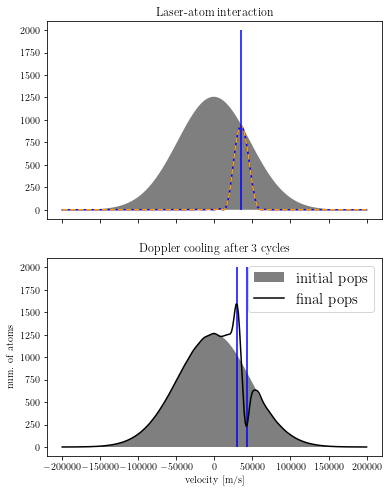

In [40]:
train = [pump_pulse_dict,dump_pulse_dict]
N_cycles = 3
pops = np.asarray([(populations[i],0) for i in range(N_bins)])
for i in range(N_cycles):
    pops = pump_dump_cycle_test(pops,train)
    
#print("Initial number of atoms:", int(np.sum(populations)), "Final number of atoms:", int(np.sum(pops)))
#print("diff between peak of interaction and trough is ~12500m/s, ~8 units of momentum, same with peak of interaction and peak in doppler cooling profile")
#print("diff in velocity between peak and trough: ~22500 m/s. One unit of photon momentum is ~1500m/s, so this is a change in about 17 units of momentum.")
ground = np.asarray([pops[i][0] for i in range(N_bins)])
excited = np.asarray([pops[i][1] for i in range(N_bins)])
total = np.sum(pops,axis=1)
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)
axs[0].fill_between(velocity_bins*1e10,0,populations,alpha=0.5)
axs[0].plot(velocity_bins*1e10,transitions_pump*populations,color="blue")
axs[0].plot(velocity_bins*1e10,transitions_dump*populations,color="orange",ls="dashed")
axs[0].set_title("Laser-atom interaction")
axs[0].vlines(35000,0,2000,color="blue")

axs[1].vlines(29500,0,2000,color="blue")
axs[1].vlines(43000,0,2000,color="blue")
axs[1].fill_between(velocity_bins*1e10,0,populations,label="initial pops",alpha=0.5)
axs[1].plot(velocity_bins*1e10,total, label="final pops")
#axs[0].plot(velocity_bins*1e10,ground,color="blue")
#axs[0].plot(velocity_bins*1e10,excited,color="orange")
axs[1].set_xlabel("velocity [m/s]")
axs[1].set_ylabel("num. of atoms")
axs[1].set_title("Doppler cooling after {} cycles".format(N_cycles))
axs[1].legend(fontsize="15")

#plt.savefig("./figures/cmt/doppler_cooling.jpg")
plt.show()

In [41]:

# need 3 dicts: 1 desymmetrization pulse, 1 broad right to left pulse, 1 broad left to right pulse
desymmetrizing_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(-200e-3),"chirp" : 2*np.pi*(30e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":-1}
broad_RL_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 0,"chirp" : 2*np.pi*(70e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":-1}
broad_LR_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 0,"chirp" : 2*np.pi*(70e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}

#evolve,evolve,evolve, then update dicts with the evolution arrays
transitions_desymmetry = evolve(velocity_bins,desymmetrizing_pulse_dict)
transitions_broad_RL = evolve(velocity_bins,broad_RL_dict)
transitions_broad_LR = evolve(velocity_bins,broad_LR_dict)



In [45]:
desymmetrizing_pulse_dict["transitions"] = transitions_desymmetry
broad_RL_dict["transitions"] = transitions_broad_RL
broad_LR_dict["transitions"] = transitions_broad_LR

99996.57426045687


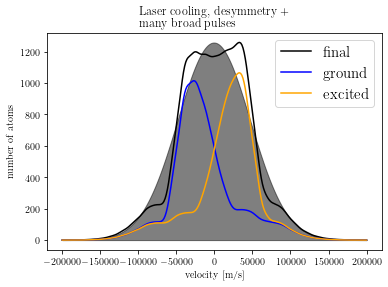

99996.5721847465


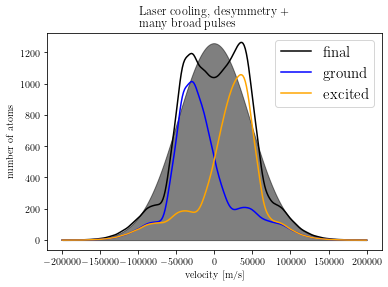

99996.57011582301


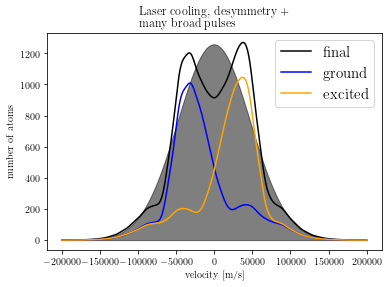

99996.5680536314


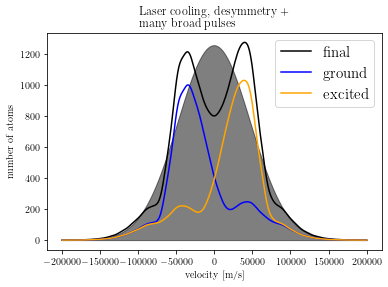

In [47]:
#train = [desymmetrizing_pulse_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict,broad_RL_dict,broad_LR_dict]
train = [desymmetrizing_pulse_dict]
N_cycles = 1

for i in range(N_cycles):
    train.append(broad_LR_dict)
    train.append(broad_RL_dict)
    if i>0:
        initial_pops = np.asarray([(populations[i],0) for i in range(N_bins)])

        pops_after_one_cycle = pump_dump_cycle_test(initial_pops,train)

        ground_after = np.asarray([pops_after_one_cycle[i][0] for i in range(N_bins)])
        excited_after = np.asarray([pops_after_one_cycle[i][1] for i in range(N_bins)])

        pops_after = np.sum(pops_after_one_cycle,axis=1)
        total_pop = np.sum(pops_after)
        print(total_pop)
        
        plt.fill_between(velocity_bins*1e10,0,populations,color="black",alpha=0.5)
        plt.plot(velocity_bins*1e10,pops_after,label="final")
        plt.plot(velocity_bins*1e10,ground_after,label="ground")
        plt.plot(velocity_bins*1e10,excited_after,label="excited")
        plt.title("Laser cooling, desymmetry + \n many broad pulses")
        plt.legend(fontsize=15)
        plt.xlabel("velocity [m/s]")
        plt.ylabel("number of atoms")
        #plt.savefig("./figures/cmt/desymmetry_plus_broad.jpg")
        plt.show()

99996.59925485916


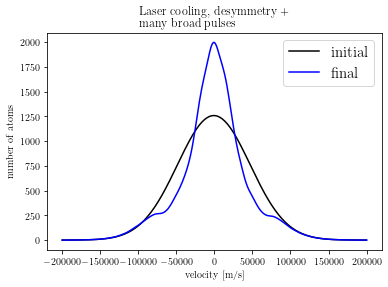

In [33]:
train